# Verifica dell'effetto fotoelettrico e misura del rapporto $h/e$

### Errore sulla fotocorrente
Si considera l'errore analogico pari allo $0.4%$ della lettura del picoamperometro.
La misura e' presa convertendo la fotocorrente in tensione, e l'errore su tale tensione dovra' includere un contributo indipendente - quello di una misura in tensione su un canale dell'AD2 con fondo scala di $200 mV/div$

### Errore sulla tensione di frenamento
La tensione di frenamento viene generata dall'AD2 e letta nel canale 1, dunque si considera l'errore associato alla misura in tensione su un canale dell'AD2.
- *con che fondo scala?*

# 0. Operazioni Preliminari

In [1]:
%pip install scipy


[notice] A new release of pip available: 22.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importo dipendenze
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.figsize"] = (12, 6)

%matplotlib inline

In [137]:
GIALLO = ("gold","darkorange")
VERDE = ("mediumseagreen","black")
VERDEACQUA = ("mediumaquamarine","blue")
BLU = ("dodgerblue","springgreen")
GRIGIO = ("dimgrey","black")

def is_sorted_by_column(l, col):
    # ritorna True se una colonna di una lista di tuple è in ordine ascendente
    return all(l[i][col] <= l[i + 1][col] for i in range(len(l) - 1))

def get_ordered_parts(_dataframe: pd.DataFrame, column_index = 0):
    # divide il dataframe in sotto-dataframe in cui i valori di tensione sono in ordine ascendente
    sorted_data = [[]]
    for row in _dataframe.iterrows():
        _v = row[1][1]
        _i = row[1][3]
        sorted_list = sorted_data[len(sorted_data)-1]
        sorted_list.append((_v, _i))
        if not is_sorted_by_column(sorted_list, column_index):
            sorted_list.pop()
            sorted_data.append([])
    return sorted_data

def remove_outliers(_dataframe: pd.DataFrame, n_sigma = 3):
    # toglie da un dataframe i dati che si discostano per più di n_sigma dalla distribuzione
    z = np.abs(stats.zscore(_dataframe["Math 1 (nA)"]))
    return _dataframe[(z < n_sigma)]

def plot_tuple_list(l, **kwargs):
    # plotta una lista di tuple (x,y)
    _x = [i[0] for i in l]
    _y = [i[1] for i in l]
    plt.plot(_x,_y, **kwargs)
    return _x, _y

def plot_tuple_list_with_y_intercept(l, **kwargs):
    _x,_y = plot_tuple_list(l, **kwargs)
    
    # get _x for _y = 0
    y0 = 0
    ___x = [i[0] for i in l if i[1] == y0]
    plt.axvline(___x[0], color="black")
    plt.axhline(y0, color="black", linestyle="dotted")

    return (___x[0],y0)

def describe_data(file_path):
    # Carico i dati con pandas
    _dataframe = pd.read_csv(file_path, comment="#")

    # Rimuovo gli outliers dal dataframe
    _dataframe = remove_outliers(_dataframe)

    # Plotto la curva I/V
    # plt.plot(df_correnti_inverse["Channel 1 (V)"],df_correnti_inverse["Math 1 (nA)"])

    # Sono ordinati nelle tensioni?
    if not _dataframe["Math 1 (nA)"].is_monotonic_increasing:

        # Divido i dati in successioni ordinate di valori di tensione
        sorted_data = get_ordered_parts(_dataframe)
        # print(sorted_data[0][0],sorted_data[0][-1],len(sorted_data[0]))
        # print(sorted_data[1][0],sorted_data[1][-1],len(sorted_data[1]))

        # Prendo la più grande
        max_sorted_list_index = 0
        for i in range(0,len(sorted_data)):
            if len(sorted_data[i]) > len(sorted_data[max_sorted_list_index]):
                max_sorted_list_index = i
        actual_data = sorted_data[max_sorted_list_index]
        print(f"Final data: {len(actual_data)}")
        print(f"Is sorted: {is_sorted_by_column(actual_data,0)}")
        print(actual_data[0],actual_data[-1])
    else:
        actual_data = zip(_dataframe.get("Channel 1 (V)"),_dataframe.get("Math 1 (nA)"))

    # Plotto la curva I/V
    plot_tuple_list(actual_data)

    return actual_data

def overlap_series(data1, data2):
    return_data = []
    for d in data1:
        for d2 in [dd[1] for dd in data2 if dd[0] == d[0]]:
            return_data.append((d[0],d[1]-d2))
    return return_data

def get_x_y(l):
    return  [i[0] for i in l],[i[1] for i in l]

# 1. Caricamento e prima analisi dei dati


### 1.1 Correnti inverse

Final data: 6210
Is sorted: True
(0.1792579021461184, 0.0059335062855334) (1.993541674891795, 0.0012372307482065)


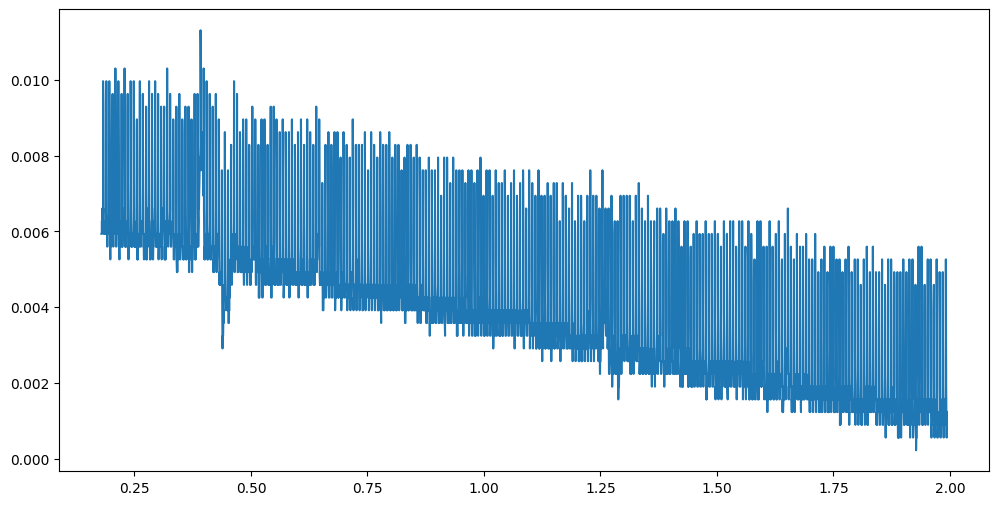

In [4]:
correnti_inverse_data = describe_data("dati/correnti_inverse.csv")

### 1.2 Corrente oscura

Final data: 6781
Is sorted: True
(0.0119194246746483, 0.0052626097802009) (1.993206997936853, 0.0012372307482065)


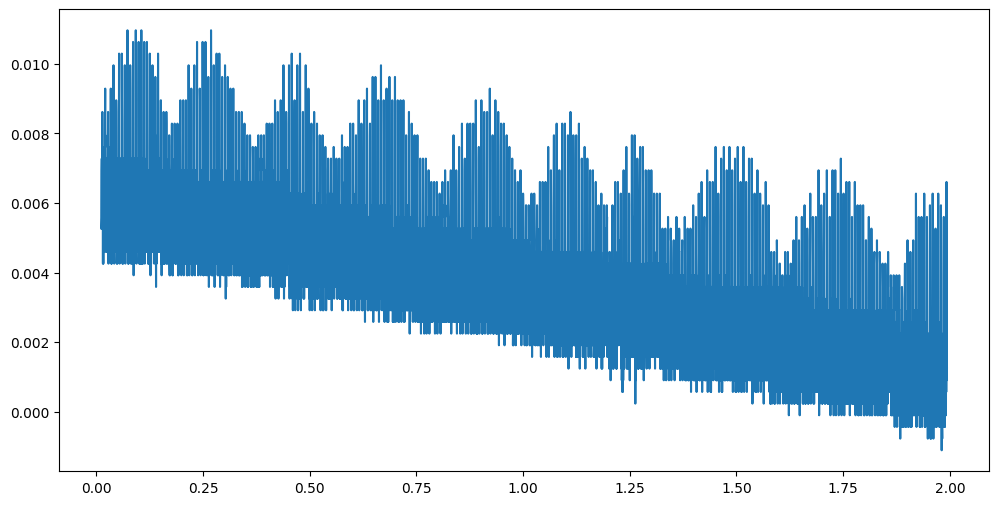

In [5]:
# Carico i dati della curva I/V della corrente oscura
corrente_oscura_data = describe_data("dati/corrente_oscura.csv")

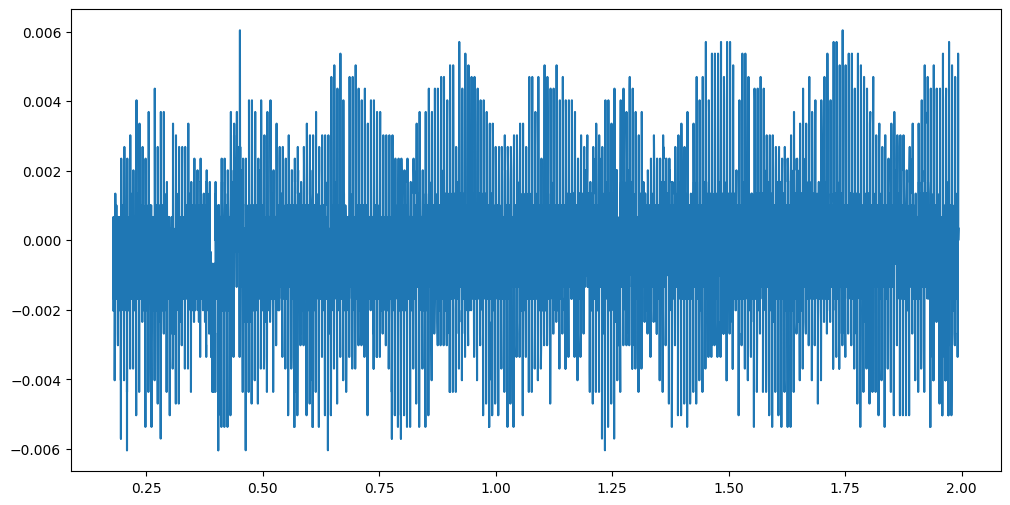

In [6]:
# sovrappongo il grafico con quello della corrente inversa sottraendo la corrente inversa
corrente_oscura_data_scaled = overlap_series(corrente_oscura_data, correnti_inverse_data)

_ = plot_tuple_list(corrente_oscura_data_scaled)

### 1.3 Giallo

Final data: 6779
Is sorted: True
(0.012588778584534, 0.5121249195588409) (1.993541674891795, -0.0024527000311217)


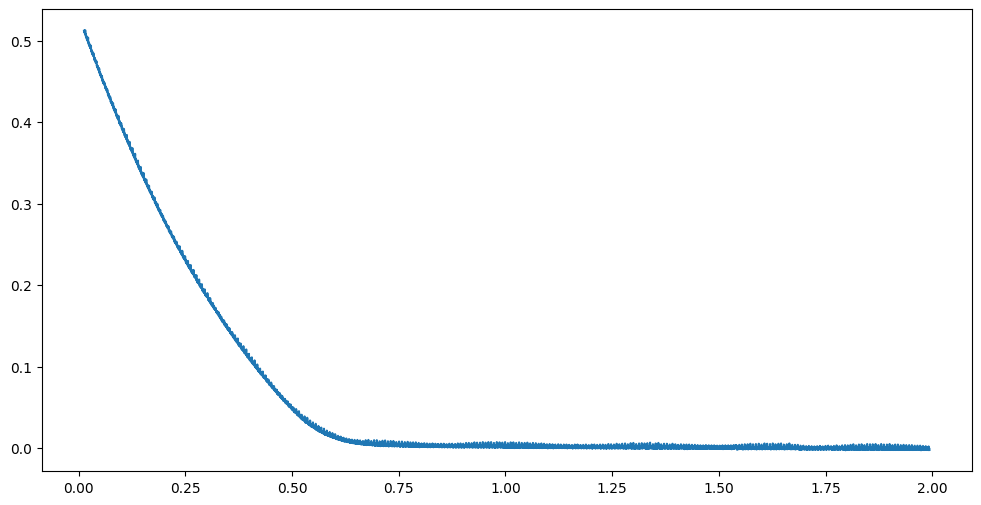

In [7]:
# Carico i dati delle curve I/V per i filtri di colore giallo, verde, verde acqua, blu 
giallo_data = describe_data("dati/giallo.csv")

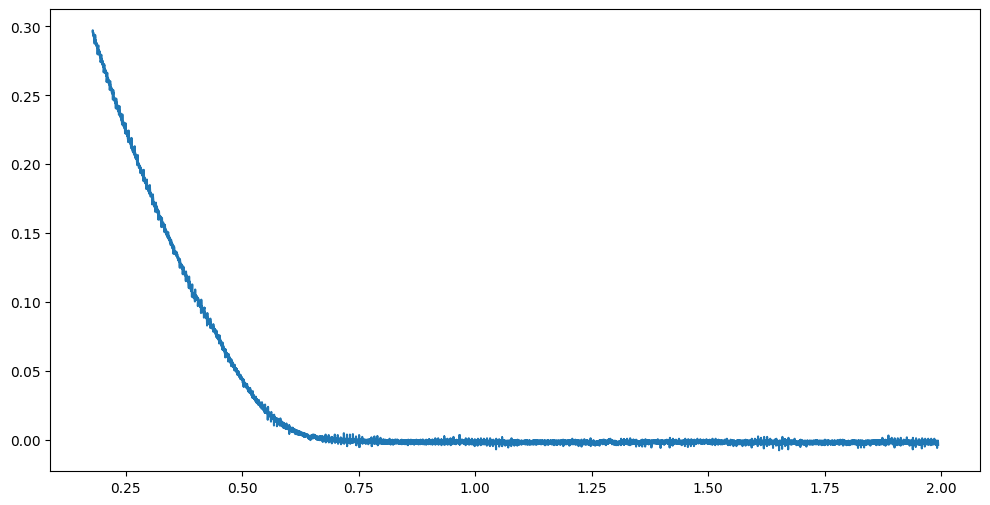

In [8]:
# sovrappongo il grafico con quello della corrente inversa sottraendo la corrente inversa
giallo_data_scaled = overlap_series(giallo_data, correnti_inverse_data)

_ = plot_tuple_list(giallo_data_scaled)

### 1.4 Verde

Final data: 6783
Is sorted: True
(0.0112500707647624, 0.588271672914069) (1.993541674891795, 0.0002308859902079)


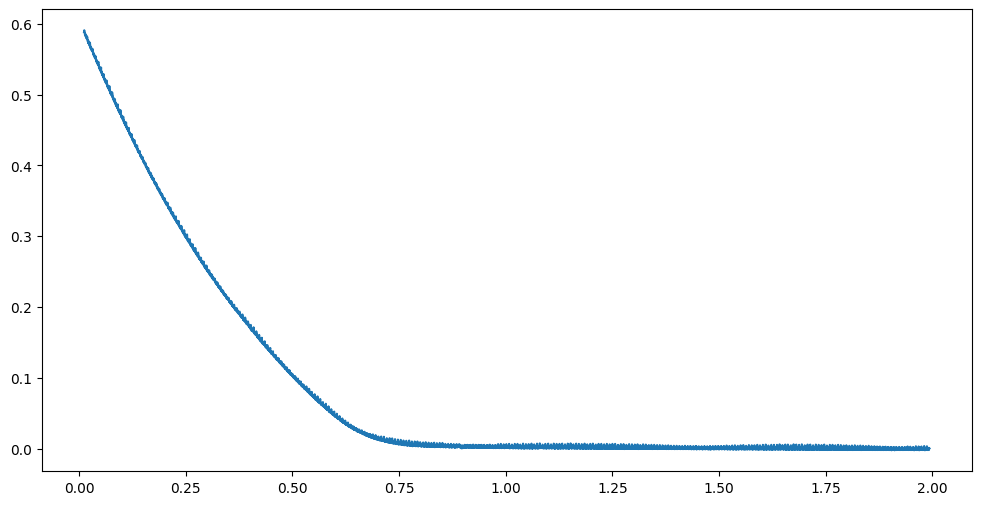

In [9]:
# Carico i dati delle curve I/V per i filtri di colore giallo, verde, verde acqua, blu 
verde_data = describe_data("dati/verde.csv")

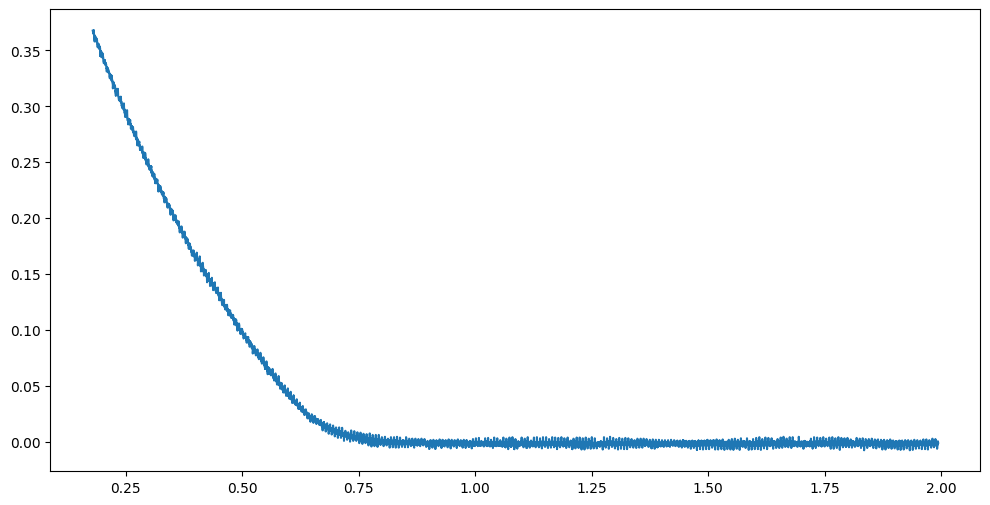

In [10]:
# sovrappongo il grafico con quello della corrente inversa sottraendo la corrente inversa
verde_data_scaled = overlap_series(verde_data, correnti_inverse_data)

_ = plot_tuple_list(verde_data_scaled)

### 1.5 Verde-Acqua

Final data: 6779
Is sorted: True
(0.012588778584534, 0.5792145700920805) (1.993206997936853, -0.0027881482837879)


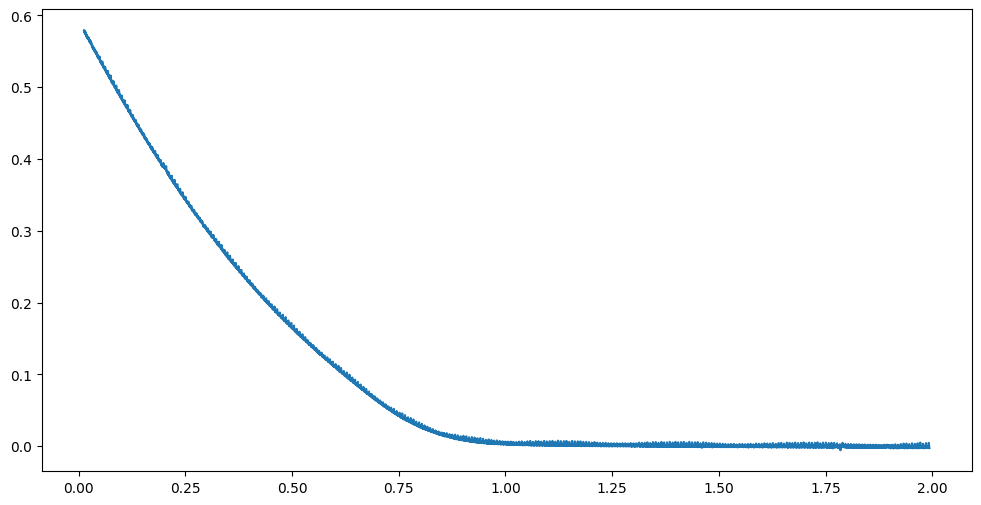

In [11]:
# Carico i dati delle curve I/V per i filtri di colore giallo, verde, verde acqua, blu 
verdeacqua_data = describe_data("dati/verdeacqua.csv")

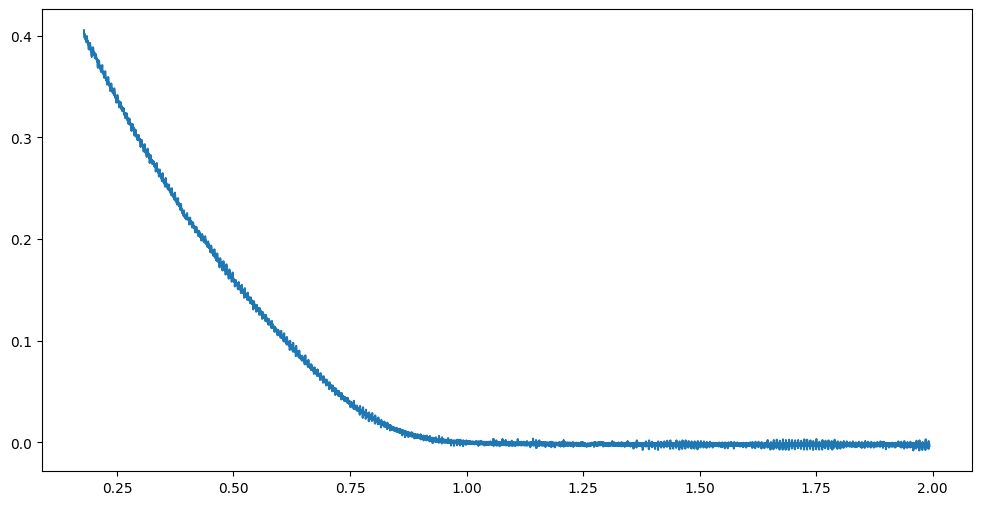

In [12]:
# sovrappongo il grafico con quello della corrente inversa sottraendo la corrente inversa
verdeacqua_data_scaled = overlap_series(verdeacqua_data, correnti_inverse_data)

_ = plot_tuple_list(verdeacqua_data_scaled)

### 1.6 Blu

Final data: 6779
Is sorted: True
(0.012588778584534, 0.771761867122485) (1.993206997936853, -0.0024527000311217)


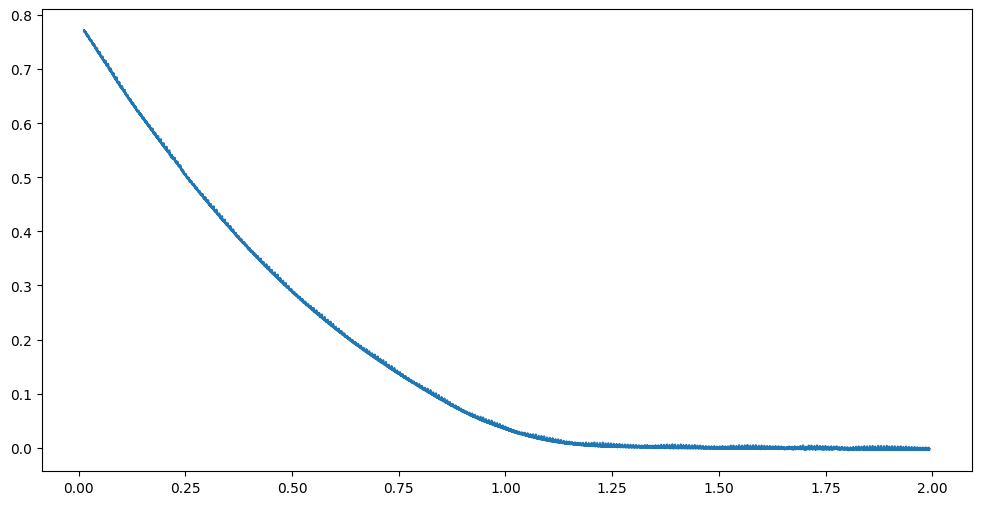

In [13]:
# Carico i dati delle curve I/V per i filtri di colore giallo, verde, verde acqua, blu 
blu_data = describe_data("dati/blu.csv")

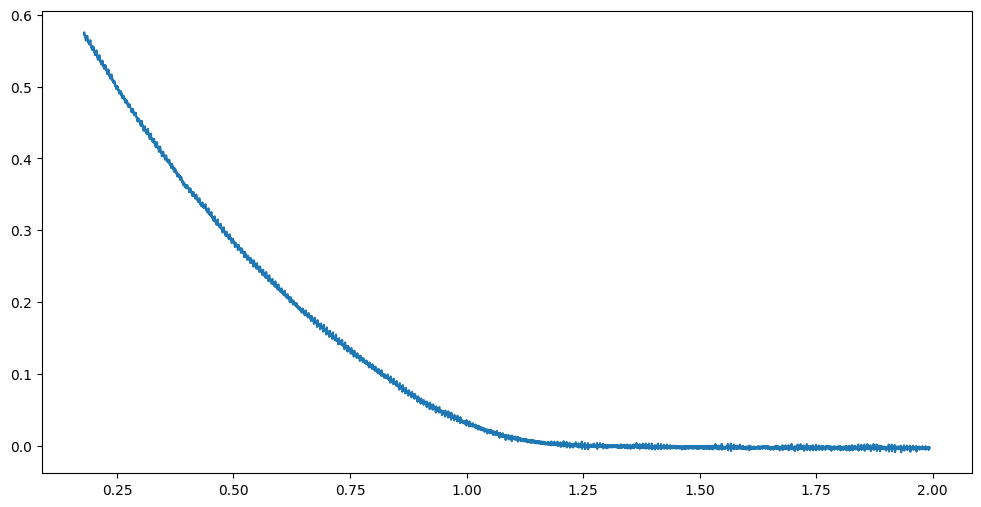

In [14]:
# sovrappongo il grafico con quello della corrente inversa sottraendo la corrente inversa
blu_data_scaled = overlap_series(blu_data, correnti_inverse_data)

_ = plot_tuple_list(blu_data_scaled)

### 1.7 Altri grafici

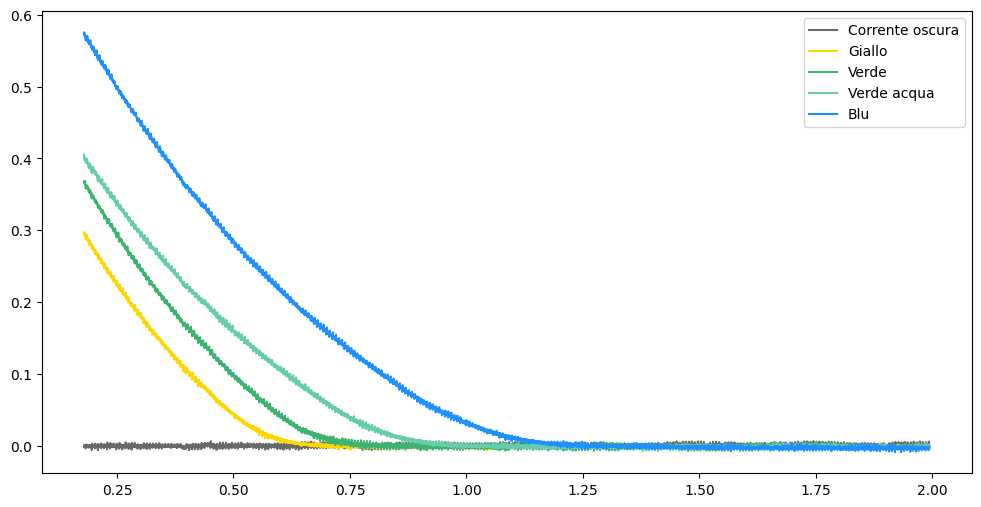

In [15]:
plot_tuple_list(corrente_oscura_data_scaled, color="dimgrey")
plot_tuple_list(giallo_data_scaled, color="gold")
plot_tuple_list(verde_data_scaled, color="mediumseagreen")
plot_tuple_list(verdeacqua_data_scaled, color="mediumaquamarine")
plot_tuple_list(blu_data_scaled, color="dodgerblue")

plt.legend(["Corrente oscura", "Giallo", "Verde", "Verde acqua", "Blu"])

# 2. Verifica dell'andamento della corrente oscura
##### Mi aspetto che la fotocorrente in assenza di illuminazione sia puramente ohmica. Questo significa che l'andamento dovrebbe risultare di proporzionalità diretta (lineare e con offset nullo)

### 2.1 Funzione di interpolazione

In [16]:
def line(x, b, I0):
    return b*x + I0

### 2.2 Interpolazione dei dati

In [71]:
_x = [i[0] for i in corrente_oscura_data]
_y = [i[1] for i in corrente_oscura_data]
popt, pcov = curve_fit(line,_x,_y)

corrente_oscura_b = popt[0]
corrente_oscura_I0 = popt[1]
print(corrente_oscura_b)
print(corrente_oscura_I0)

-0.002572079424237015
0.006350213419619005


# 3. Stima preliminare della tensione di azzeramento della fotocorrente $V_0$

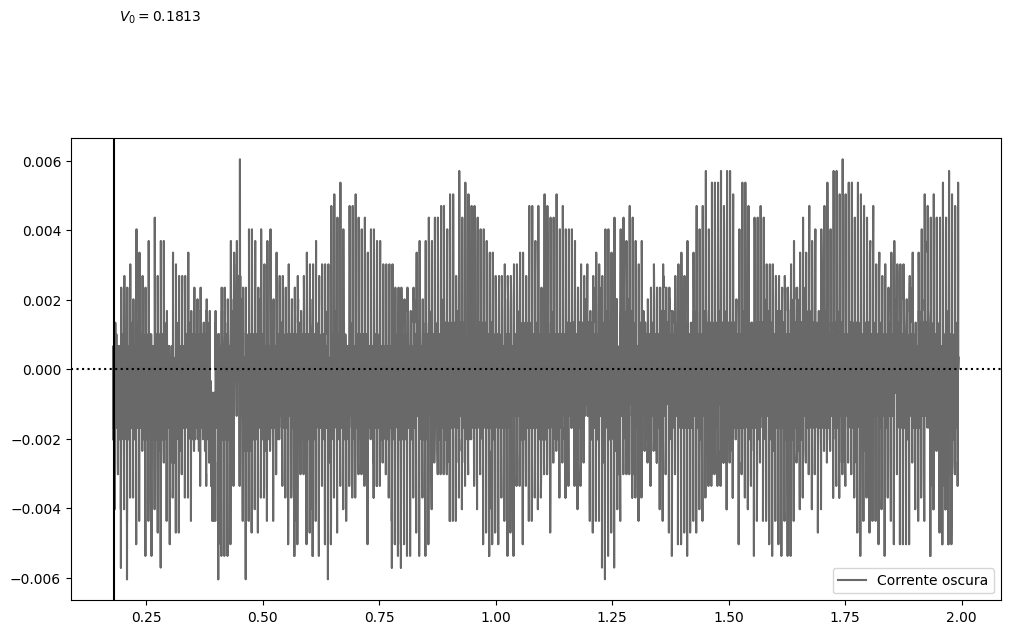

In [136]:
intercept_oscura = plot_tuple_list_with_y_intercept(corrente_oscura_data_scaled,color="dimgrey")
plt.annotate(f"$V_0 = {intercept_oscura[0]:.4f}$", xy=intercept_oscura, xytext=(intercept_oscura[0]+0.01,intercept_oscura[1]+0.01))
plt.legend(["Corrente oscura"])

### 3.1 Giallo

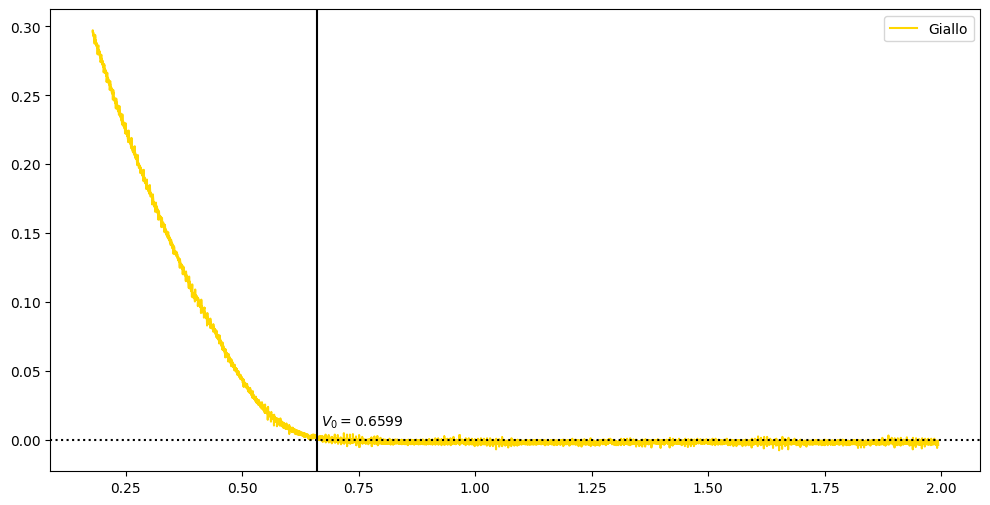

In [73]:
intercept_giallo = plot_tuple_list_with_y_intercept(giallo_data_scaled,color="gold")
plt.annotate(f"$V_0 = {intercept_giallo[0]:.4f}$", xy=intercept_giallo, xytext=(intercept_giallo[0]+0.01,intercept_giallo[1]+0.01))
plt.legend(["Giallo"])

### 3.2 Verde

[0.7314748778019692, 0.7619304807017767, 0.7860272214576683, 0.7913820527367554, 0.7923860836015842, 0.7940594683762989, 0.7947288222861848, 0.7974062379257283, 0.799079622700443, 0.8000836535652718, 0.8020917152949295, 0.8027610692048154, 0.8027610692048154, 0.8040997770245871, 0.8071118696190736, 0.810793316123446, 0.8141400856728753, 0.81581347044759, 0.81581347044759, 0.8184908860871335, 0.8194949169519623, 0.8201642708618482, 0.8201642708618482, 0.8204989478167912, 0.8278618408255358, 0.8355594107892235, 0.8365634416540523, 0.8392408572935958, 0.8422529498880822, 0.8486118120319981, 0.8506198737616557, 0.8512892276715416, 0.8516239046264846, 0.8553053511308569, 0.8619988902297158, 0.8633375980494875, 0.8663496906439739, 0.8696964601934033, 0.8737125836527186, 0.8787327379768627, 0.8804061227515774, 0.8860956309856074, 0.8927891700844661, 0.893793200949295, 0.9021601248228686, 0.9024948017778114, 0.9065109252371268, 0.9122004334711566, 0.9132044643359856, 0.9195633264799014, 0.9219

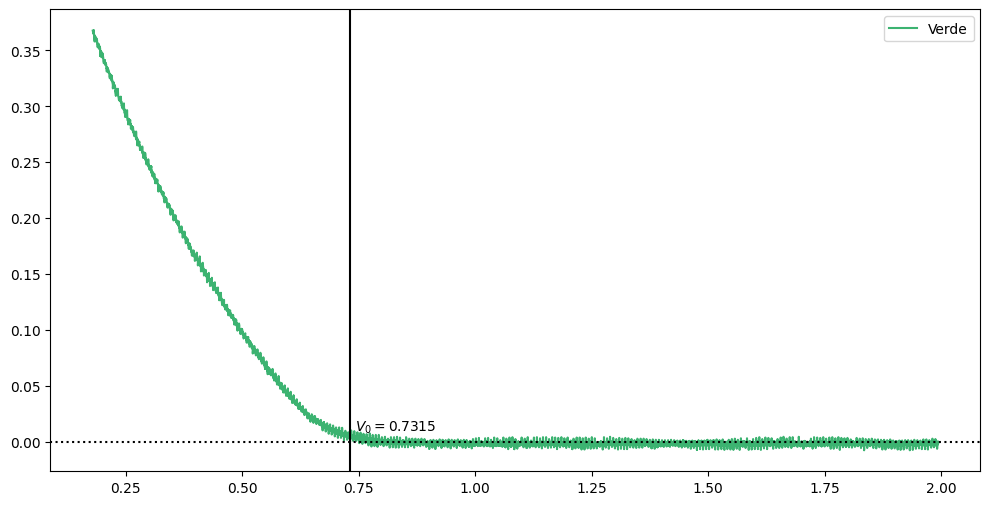

In [19]:
intercept_verde = plot_tuple_list_with_y_intercept(verde_data_scaled,color="mediumseagreen")
plt.annotate(f"$V_0 = {intercept_verde[0]:.4f}$", xy=intercept_verde, xytext=(intercept_verde[0]+0.01,intercept_verde[1]+0.01))
plt.legend(["Verde"])

### 3.3 Verde acqua

[0.927260896443589, 0.9503536063346518, 0.95470440674891, 0.959724561073054, 0.9644100384422554, 0.9644100384422554, 0.9731116392707716, 0.97746243968503, 0.9804745322795164, 0.9878374252882612, 0.988172102243204, 0.988172102243204, 0.9921882257025192, 0.9958696722068916, 1.000555149576093, 1.004905949990351, 1.013607550818868, 1.016284966458411, 1.017958351233126, 1.022309151647384, 1.026994629016585, 1.028333336836357, 1.028333336836357, 1.0310107524759, 1.035696229845102, 1.037034937664873, 1.037034937664873, 1.04004703025936, 1.044397830673618, 1.045401861538447, 1.052095400637306, 1.055442170186735, 1.056780878006507, 1.056780878006507, 1.057784908871336, 1.061131678420765, 1.061131678420765, 1.065482478835023, 1.066486509699852, 1.06849457142951, 1.069833279249281, 1.07083731011411, 1.072845371843768, 1.072845371843768, 1.075188110528368, 1.076192141393197, 1.079538910942627, 1.080542941807455, 1.081881649627227, 1.084893742221714, 1.086232450041485, 1.088240511771143, 1.09259131

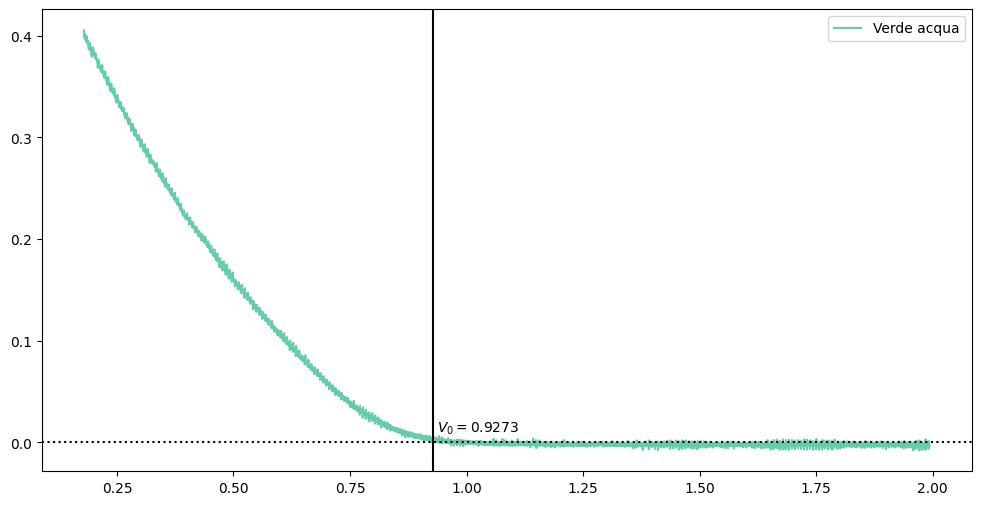

In [20]:
intercept_verdeacqua = plot_tuple_list_with_y_intercept(verdeacqua_data_scaled,color="mediumaquamarine")
plt.annotate(f"$V_0 = {intercept_verdeacqua[0]:.4f}$", xy=intercept_verdeacqua, xytext=(intercept_verdeacqua[0]+0.01,intercept_verdeacqua[1]+0.01))
plt.legend(["Verde acqua"])

### 3.4 Blu

[1.205377446001172, 1.206381476866001, 1.207720184685773, 1.20972824641543, 1.210732277280259, 1.212070985100031, 1.212740339009917, 1.213409692919803, 1.217760493334061, 1.217760493334061, 1.220772585928547, 1.220772585928547, 1.228804832847178, 1.23248627935155, 1.234494341081208, 1.241857234089953, 1.244199972774553, 1.245538680594325, 1.249220127098697, 1.251897542738241, 1.251897542738241, 1.257252374017328, 1.257252374017328, 1.259260435746985, 1.259595112701928, 1.261603174431586, 1.263945913116187, 1.263945913116187, 1.263945913116187, 1.263945913116187, 1.265284620935958, 1.271308806124931, 1.280010406953448, 1.281349114773219, 1.281683791728162, 1.287707976917135, 1.294401516015994, 1.294736192970937, 1.298082962520366, 1.299421670340138, 1.301095055114853, 1.30310311684451, 1.304107147709339, 1.305445855529111, 1.305445855529111, 1.306115209438997, 1.307453917258769, 1.308457948123598, 1.309796655943369, 1.309796655943369, 1.314147456357627, 1.315151487222456, 1.320840995456

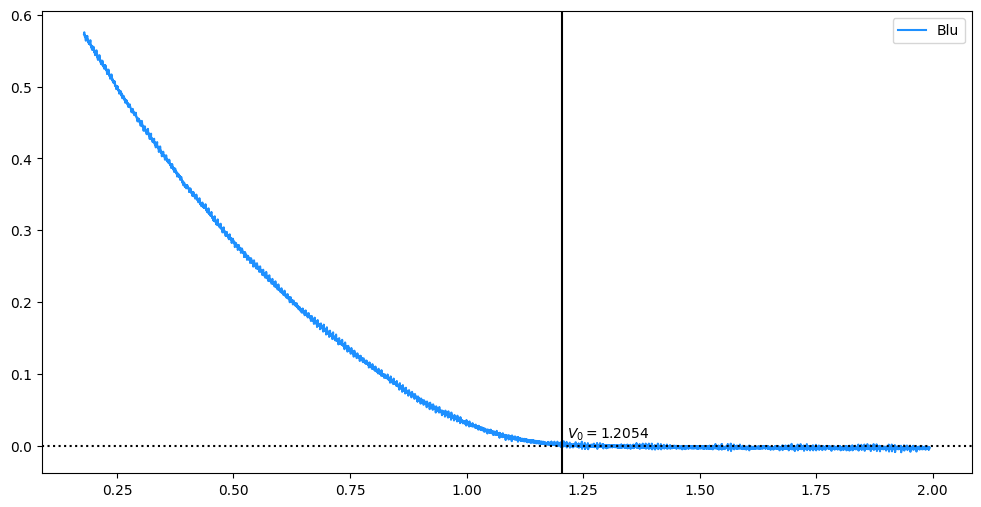

In [43]:
intercept_blu = plot_tuple_list_with_y_intercept(blu_data_scaled,color="dodgerblue")
plt.annotate(f"$V_0 = {intercept_blu[0]:.4f}$", xy=intercept_blu, xytext=(intercept_blu[0]+0.01,intercept_blu[1]+0.01))
plt.legend(["Blu"])

[0.65985400944418, 0.6621967481287806, 0.6621967481287806, 0.6632007789936094, 0.6642048098584382, 0.6655435176782101, 0.666212871588096, 0.6675515794078677, 0.6705636720023541, 0.670898348957297, 0.6739104415517835, 0.6752491493715553, 0.6782612419660417, 0.6782612419660417, 0.6809386576055853, 0.6826120423802999, 0.6856241349747865, 0.6896402584341017, 0.6903096123439876, 0.693321704938474, 0.7026926596768763, 0.7070434600911346, 0.7097208757306781, 0.7127329683251645, 0.715745060919651, 0.7217692461086239, 0.7257853695679392, 0.7301361699821973, 0.7301361699821973, 0.732478908666798, 0.7334829395316268, 0.7344869703964556, 0.7411805094953143, 0.7411805094953143, 0.7458659868645156, 0.7465353407744014, 0.7478740485941733, 0.7502167872787737, 0.7522248490084315, 0.7535635568282032, 0.754567587693032, 0.754567587693032, 0.759922418972119, 0.7612611267918908, 0.7622651576567196, 0.7632691885215485, 0.765611927206149, 0.7686240198006355, 0.7699627276204073, 0.7699627276204073, 0.77297482

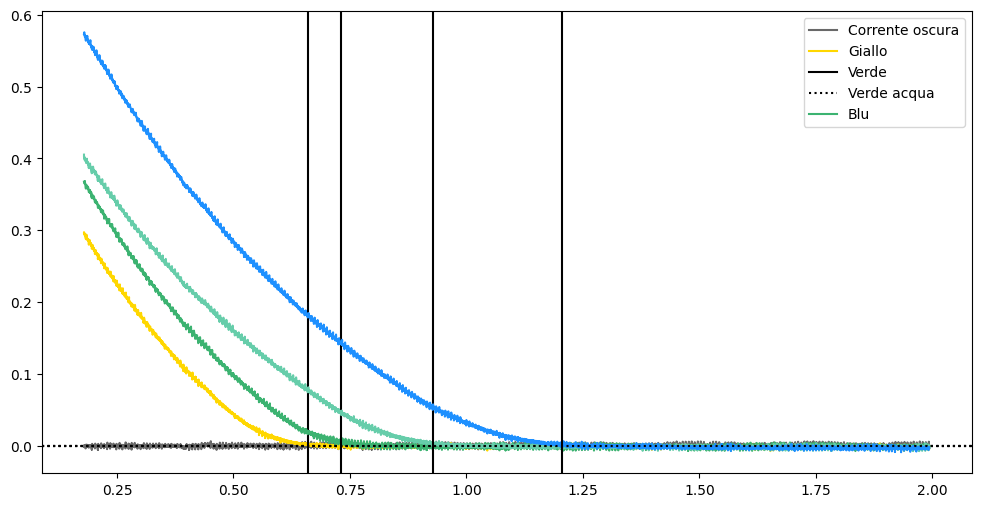

In [41]:
plot_tuple_list(corrente_oscura_data_scaled, color=GRIGIO)
plot_tuple_list_with_y_intercept(giallo_data_scaled, color=GIALLO[0])
plot_tuple_list_with_y_intercept(verde_data_scaled, color=VERDE[0])
plot_tuple_list_with_y_intercept(verdeacqua_data_scaled, color=VERDEACQUA[0])
plot_tuple_list_with_y_intercept(blu_data_scaled, color=BLU[0])

plt.legend(["Corrente oscura", "Giallo", "Verde", "Verde acqua", "Blu"])

# 4. Stima della tensione di azzeramento della fotocorrente $V_0$ con fit

### 4.1 Funzione di interpolazione
$$I(V) = a(V_0 - V)^\alpha \Theta(V_0-V)+bV+I_0$$

In [180]:

def fn(V,a,V0,alpha,b,I0): #NOSONAR
    return a * (np.abs(V0-V)**alpha) * np.where(V0>V,1,0) + b*V + I0

def fit_fn(V, V0, a): #NOSONAR
    return fn(V, a, V0, 2.5, corrente_oscura_b, corrente_oscura_I0)

def fit(data, intercept_data, label, color, fit_color, xy_text=[(1.5,0.2),(1.5,0.1)]):
    # Giallo
    _x, _y = get_x_y(data)
    sigma_x,sigma_y = [(0.4/100)*i + 0.0058 for i in _x], [(0.4/100)*i for i in _y]

    init = (intercept_data[0],1)
    popt, pcov = curve_fit(fit_fn,_x,_y,sigma=sigma_y,p0=init)
    err = np.sqrt(np.diag(pcov))
    
    print(f"Parametri ottimali:\nV0: ({popt[0]:.4f} +- {err[0]:.4f})\na: ({popt[1]:.4f} +- {err[1]:.4f})")
    print(f"V0 dalla stima preliminare: {intercept_data[0]:.4f}")
    
    # Define linspace
    _x_lin = np.linspace(min(_x), max(_x), len(_x)*10)

    # Plot
    plt.plot(_x_lin, fit_fn(_x_lin, *popt), label=f"Fit {label}", color=fit_color)
    plt.scatter(_x, _y, label=label, color=color)
    plt.legend()
    plt.ylabel("I $[nA]$")
    plt.xlabel("V $[V]$")

    plt.axvline(intercept_data[0], color="black", linestyle="dotted")
    plt.axvline(popt[0], color="black")
    plt.axhline(0, color="black", linestyle="dotted")
    # plt.annotate(f"$V_0 = {intercept_giallo[0]:.4f}$", xy=intercept_giallo, xytext=(intercept_giallo[0]+0.01,intercept_giallo[1]+0.01))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(xy_text[0][0], xy_text[0][1],
            f"$V_0 = ({np.round(popt[0],4)}\pm{np.round(err[0],4)})V$ (fit)\n$V_0 = {np.round(intercept_data[0],4)}V$ (intercetta)",
            fontsize=10, verticalalignment='top', bbox=props)
    plt.text(xy_text[1][0], xy_text[1][1],
            f"$a = ({np.round(popt[1],4)}\pm{np.round(err[1],4)})$ (fit)",
            fontsize=10, verticalalignment='top', bbox=props)


    return popt, err


### 4.2 Interpolazione dei dati

Parametri ottimali:
V0: (0.7339 +- 0.0275)
a: (1.3657 +- 0.3181)
V0 dalla stima preliminare: 0.6599


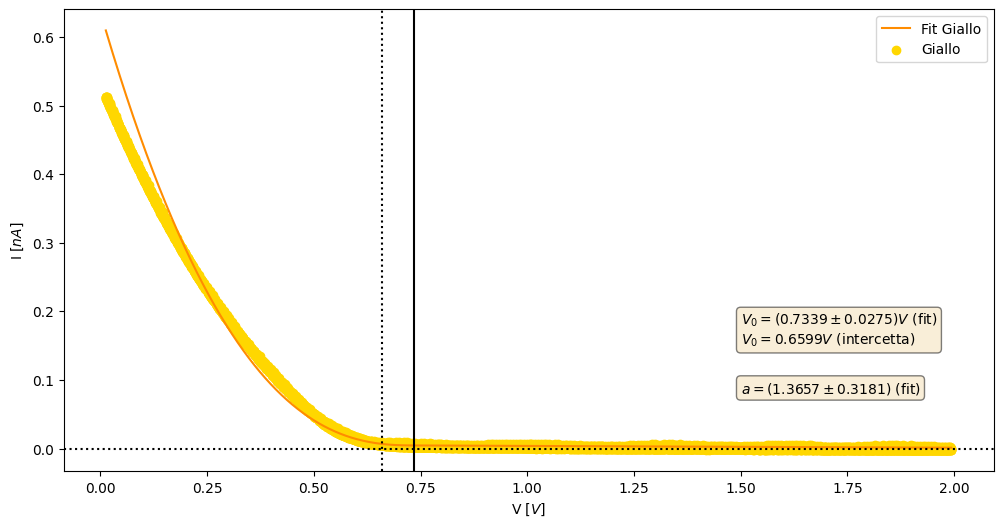

In [181]:
# Giallo
sigma_x = []
popt,err = fit(giallo_data, intercept_giallo,"Giallo",*GIALLO)

Parametri ottimali:
V0: (0.8529 +- 0.0256)
a: (1.0726 +- 0.2071)
V0 dalla stima preliminare: 0.7315


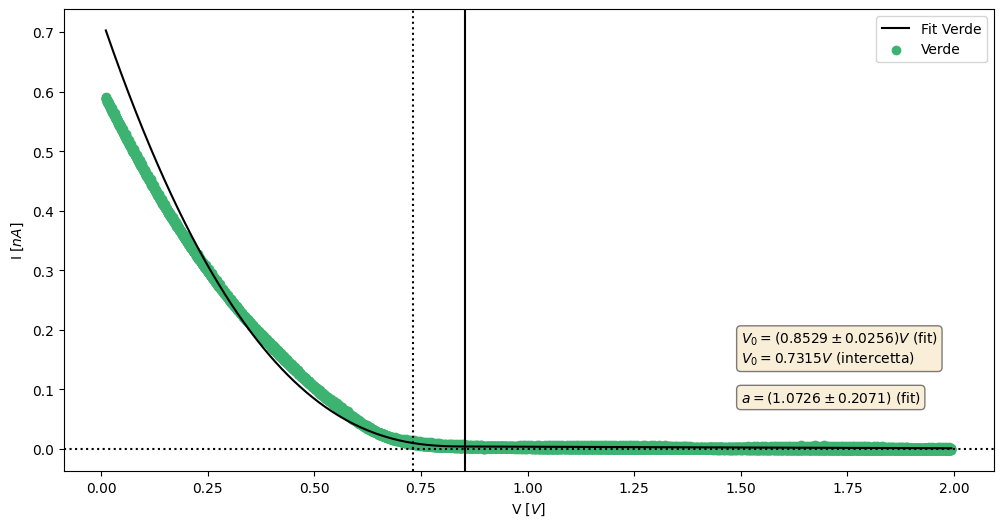

In [182]:
popt,err = fit(verde_data,intercept_verde, "Verde", *VERDE)

Parametri ottimali:
V0: (1.0520 +- 0.0265)
a: (0.6302 +- 0.1027)
V0 dalla stima preliminare: 0.9273


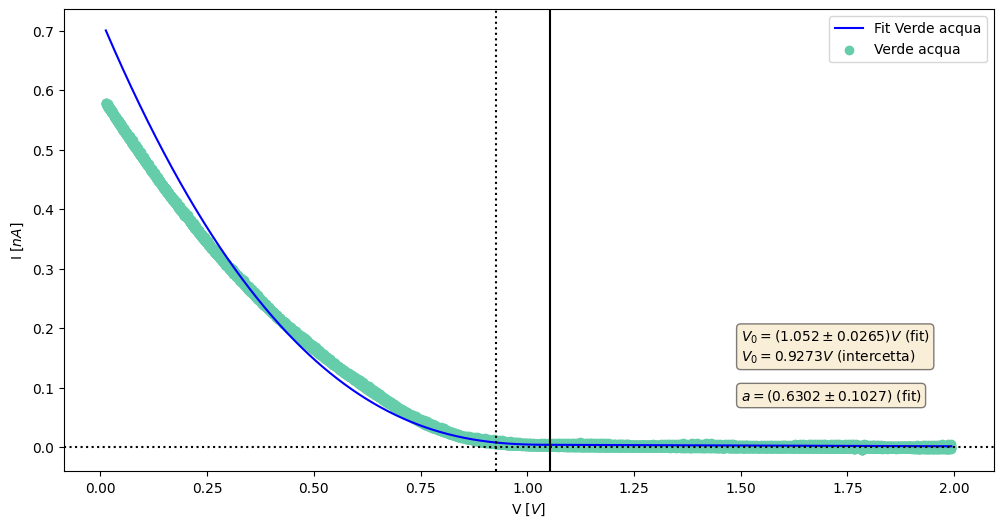

In [183]:
popt,err = fit(verdeacqua_data,intercept_verdeacqua,"Verde acqua",*VERDEACQUA)

Parametri ottimali:
V0: (1.2992 +- 0.0208)
a: (0.4967 +- 0.0535)
V0 dalla stima preliminare: 1.2054


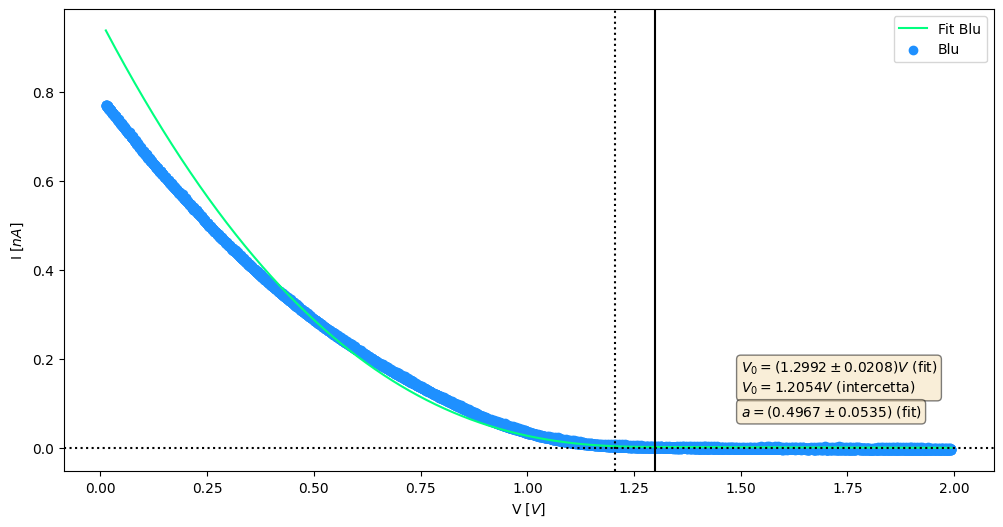

In [184]:
popt,err = fit(blu_data,intercept_blu,"Blu",*BLU)

In [ ]:
from scipy.optimize import leastsq

def multiple_reg(x, y, f, const, params0, **kwargs):
    """Do same non-linear regression on multiple curves
    """

    def leastsq_func(params, *args):
        x, y = args[:2]
        const = args[2:]
        yfit = []
        for i in range(len(x)):
            yfit = np.append(yfit, f(x[i],*const[i],*params))
        return y-yfit

    # turn const into 2d-array if 1d is given
    const = np.asarray(const)
    if len(const.shape) < 2:
        const = np.atleast_2d(const).T

    # ensure that y is flat and x is nested
    if hasattr(y[0], "__len__"):
        y = [item for sublist in y for item in sublist]
    if not hasattr(x[0], "__len__"):
        x = np.tile(x, (len(const), 1))
    x_ = [item for sublist in x for item in sublist]
    assert len(x_) == len(y)

    # collect all arguments in a tuple
    y = np.asarray(y)
    args=[x,y] + list(const)
    args=tuple(args)   #doesn't work if args is a list!!

    return leastsq(leastsq_func, params0, args=args, **kwargs)

_x,_y = get_x_y(giallo_data)
multiple_reg(_x,_y,fn,)